<a href="https://colab.research.google.com/github/4232177191/neumerical-dataset/blob/main/wine_cosine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

لطفاً تعداد تکرار را وارد کنید: 8


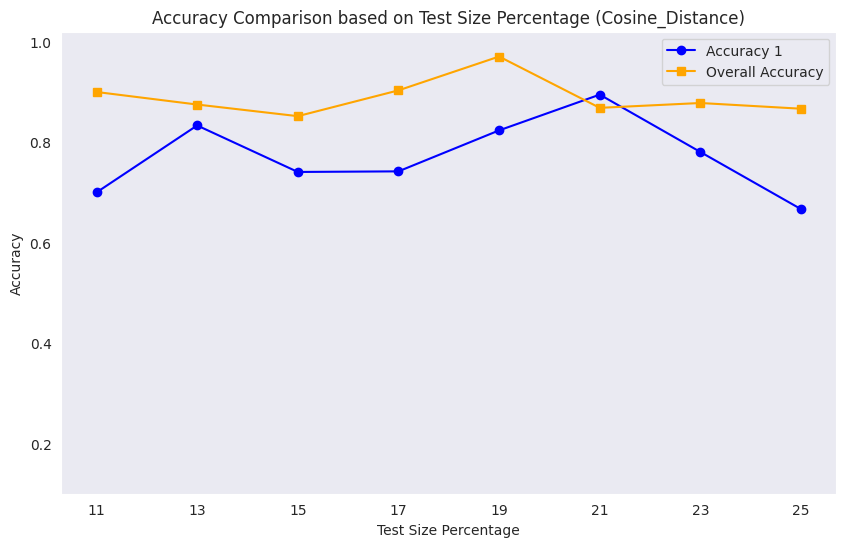

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import mode
from seaborn import set_style
set_style('darkgrid')

# تعریف متریک کسینوسی
def cosine_distance(x, y):
    x_norm = np.linalg.norm(x)
    y_norm = np.linalg.norm(y)
    return 1-(np.sum(x * y ) / (x_norm * y_norm + 1e-10))

# تابع برای محاسبه دقت
def calculate_accuracy(dataset, test_size=0.2, features_to_use=None):
    X = dataset.drop(columns=["target"]).values  # ویژگی‌ها
    y = dataset["target"].values  # برچسب‌ها

    # تقسیم داده‌ها به مجموعه آموزش و تست
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # مقیاس‌گذاری داده‌ها
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    predicted_labels_per_feature = []
    k = int(np.sqrt(len(y_train)))  # تعداد همسایه‌ها
    model = KNeighborsClassifier(n_neighbors=k, metric=cosine_distance)

    # پردازش ویژگی‌های مشخص شده
    for i in features_to_use:
        X_train_feature = X_train_scaled[:, [i]]
        model.fit(X_train_feature, y_train)
        predicted_labels = model.predict(X_test_scaled[:, [i]])
        predicted_labels_per_feature.append(predicted_labels)

    if predicted_labels_per_feature:  # بررسی اینکه آیا پیش‌بینی انجام شده است
        final_predictions = np.array(predicted_labels_per_feature).T  # ترانهاده کردن
        final_target_predictions = mode(final_predictions, axis=1)[0].flatten()
    else:
        raise ValueError("No predictions were made.")

    overall_accuracy = accuracy_score(y_test, final_target_predictions)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy1 = accuracy_score(y_test, y_pred)

    return accuracy1, overall_accuracy

# بارگذاری دیتاست بریست کنسر
wine = datasets.load_wine()
data = pd.DataFrame(wine.data, columns=wine.feature_names)
data["target"] = wine.target  # اصلاح نام متغیر به wine.target

# تعداد تکرار
def run_knn(iterations):
    feature_counts = {feature: 0 for feature in wine.feature_names}  # شمارش ویژگی‌ها
    all_accuracy_results = []

    for _ in range(iterations):
        test_size = np.random.uniform(0.1, 0.3)  # انتخاب تصادفی اندازه تست
        accuracy1, overall_accuracy = calculate_accuracy(data, test_size=test_size, features_to_use=range(len(wine.feature_names)))
        all_accuracy_results.append((accuracy1, overall_accuracy))

        # شمارش ویژگی‌هایی که دقت آنها بالای 75% بوده است
        if overall_accuracy > 0.75:
            for feature in wine.feature_names:
                feature_counts[feature] += 1

    return all_accuracy_results, feature_counts

# تعداد تکرار
iterations = int(input("لطفاً تعداد تکرار را وارد کنید: "))
all_accuracy_results, feature_counts = run_knn(iterations)

# جمع آوری ویژگی‌هایی که دقتشان بالای 75% بوده است
features_above_75_each_time = [feature for feature, count in feature_counts.items() if count == iterations]
feature_indices = [list(wine.feature_names).index(feature) for feature in features_above_75_each_time]

# بررسی دقت‌ها در درصدهای مختلف
test_sizes = np.arange(0.11, 0.25, 0.02)  # از 11% تا 25% با گام 2%
accuracy1_list = []
overall_accuracy_list = []

for test_size in test_sizes:
    accuracy1, overall_accuracy = calculate_accuracy(data, test_size=test_size, features_to_use=feature_indices)
    accuracy1_list.append(accuracy1)
    overall_accuracy_list.append(overall_accuracy)

# رسم نمودار
plt.figure(figsize=(10, 6))
plt.plot(test_sizes * 100, accuracy1_list, marker='o', label='Accuracy 1', color='blue')
plt.plot(test_sizes * 100, overall_accuracy_list, marker='s', label='Overall Accuracy', color='orange')
plt.title('Accuracy Comparison based on Test Size Percentage (Cosine_Distance)')
plt.xlabel('Test Size Percentage')
plt.ylabel('Accuracy')
plt.xticks(test_sizes * 100)
plt.ylim(0.1, 1.02)
plt.legend()
plt.grid()

plt.show()